In [79]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

seed = 12345
rng = np.random.default_rng(seed)  # can be called without a seed
rng.random()

df = pd.read_csv (r"C:\Users\White\Desktop\tfg\generados\dft2.csv")


df=df.drop(["Src Port"], axis=1)
df=df.drop(["Dst Port"], axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336090 entries, 0 to 336089
Data columns (total 60 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Tot Fwd Pkts        336090 non-null  int64  
 1   TotLen Bwd Pkts     336090 non-null  float64
 2   Fwd Pkt Len Min     336090 non-null  int64  
 3   Fwd Pkt Len Mean    336090 non-null  float64
 4   Bwd Pkt Len Max     336090 non-null  int64  
 5   Bwd Pkt Len Min     336090 non-null  int64  
 6   Flow Byts/s         336090 non-null  float64
 7   Flow IAT Mean       336090 non-null  float64
 8   Flow IAT Min        336090 non-null  float64
 9   Fwd IAT Tot         336090 non-null  float64
 10  Fwd IAT Mean        336090 non-null  float64
 11  Fwd IAT Max         336090 non-null  float64
 12  Fwd IAT Min         336090 non-null  float64
 13  Bwd IAT Tot         336090 non-null  float64
 14  Bwd IAT Mean        336090 non-null  float64
 15  Bwd IAT Max         336090 non-nul

In [40]:
# Isolation Forest ----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


X = df.copy()
y = X.pop("LabelA")
# training the model
clf = IsolationForest(n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.01,
                n_jobs        = -1,
                random_state  = 123)


In [41]:
clf.fit(X)

IsolationForest(contamination=0.01, n_estimators=1000, n_jobs=-1,
                random_state=123)

In [42]:
score_anomalia = clf.score_samples(X)

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    score_anomalia,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(clf.offset_, c='red', linestyle='--', label='cuantil 0.01')
ax.set_title('Distribución de los valores de anomalía')
ax.set_xlabel('Score de anomalía');

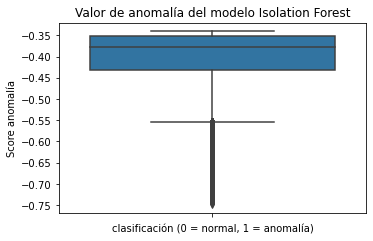

In [44]:
# Distribución de los valores de anomalía
# ==============================================================================
df_resultados = pd.DataFrame({
                    'score'    : score_anomalia,
                })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    y     = 'score',
    data  = df_resultados,
    #color = "white",
    palette = 'tab10',
    ax    = ax
)

ax.set_title('Valor de anomalía del modelo Isolation Forest')
ax.set_ylabel('Score anomalía')
ax.set_xlabel('clasificación (0 = normal, 1 = anomalía)');

In [45]:
# Matriz de confusión de la clasificación final
# ==============================================================================
df_resultados = df_resultados \
                .sort_values('score', ascending=True) \
                .reset_index(drop=True)

#df_resultados['clasificacion'] = np.where(df_resultados.index <= 176, 1, 0)


In [46]:
df['clasificacion'] = np.where(df_resultados['score']<-0.65,1,0)


In [47]:
dft=pd.concat([df, df_resultados], axis=1)
dfOutliers=dft[dft["clasificacion"]==1]
dfOutliersDe=dft[dft["clasificacion"]==0]


In [48]:
dfOutliers["LabelA"].value_counts()

1    2180
Name: LabelA, dtype: int64

In [49]:
dfOutliers.to_csv(r"C:\Users\White\Desktop\tfg\generados\outliers2.csv", index = None, header=True) 


In [50]:
dfOutliersDe.to_csv(r"C:\Users\White\Desktop\tfg\generados\Deoutliers2.csv", index = None, header=True) 


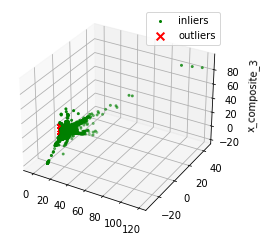

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

outlier_index=list(dfOutliers.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [17]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df)
res=pd.DataFrame(pca.transform(df))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [18]:
from scipy import stats
dfOutliersZ=df.copy()
dfOutliersZ=dfOutliersZ[(np.abs(stats.zscore(dfOutliersZ)) < 3).all(axis=1)]

In [19]:
dfOutliersZ.info()
dfOutliersZ["LabelA"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197419 entries, 1710 to 335900
Data columns (total 63 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Src Port            197419 non-null  int64  
 1   Dst Port            197419 non-null  int64  
 2   Tot Fwd Pkts        197419 non-null  int64  
 3   Fwd Pkt Len Min     197419 non-null  int64  
 4   Fwd Pkt Len Mean    197419 non-null  float64
 5   Bwd Pkt Len Max     197419 non-null  int64  
 6   Bwd Pkt Len Min     197419 non-null  int64  
 7   Flow Byts/s         197419 non-null  float64
 8   Flow IAT Mean       197419 non-null  float64
 9   Flow IAT Min        197419 non-null  float64
 10  Fwd IAT Tot         197419 non-null  float64
 11  Fwd IAT Mean        197419 non-null  float64
 12  Fwd IAT Max         197419 non-null  float64
 13  Fwd IAT Min         197419 non-null  float64
 14  Bwd IAT Tot         197419 non-null  float64
 15  Bwd IAT Mean        197419 non-

1    196727
0       692
Name: LabelA, dtype: int64

In [20]:
dfOutliersZ.to_csv(r"C:\Users\White\Desktop\tfg\generados\outliersZ.csv", index = None, header=True) 


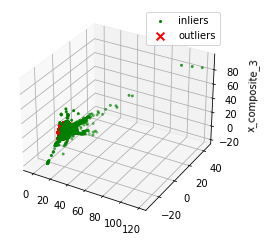

In [21]:
from sklearn.decomposition import PCA
outlier_index=list(dfOutliersZ.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

# Interquartile range outlier

In [105]:
data=df.copy()
i=0
filtered_data=data.copy() 
for col in data.columns:
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR)) 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    for x in data[col]:
        print (i)
        if ((x < lower_range) or (x > upper_range)):
            data.drop(data.index[data[col] == x], inplace=True)
            i=i+1
# Assigning filtered data back to our original variable
print("Shape of data after outlier removal is: ", data.shape)


IQR value for column Tot Fwd Pkts is: 2.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


4
4
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
8
8
8
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
11
11
11
12
12
12
12
12
13
13
14
14
14
14
15
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
19
19
19
19
19
20
20
20
20
20
20
20
20
21
21
21
21
21
22
22
22
23
23
23
23
24
24
25
26
26
26
26
26
26
27
27
27
27
27
27
28
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
31
31
32
33
33
33
34
35
36
37
38
38
39
40
41
41
42
42
43
43
43
43
43
43
43
43
44
45
46
46
46
46
47
47
48
48
49
50
50
51
51
52
53
53
53
54
54
55
55
56
56
56
57
57
58
59
60
60
60
61
61
62
62
63
64
65
66
67
68
69
70
71
72
72
73
74
74
75
75
76
76
77
77
78
79
79
80
81
81
82
83
83
84
85
85
86
87
87
88
89
89
90
90
91
92
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
94
95
96
97
98
98
98
98
98
99
100
101
102
103
104
105
106
107
107
108
108
109
110
111
112
113
114
115
116
117
118
119
120
120
121
122
123
124
125
126
127
128
129
129
130
131
132
132
132
133
134
135
136
137
138
139
140
140
140

341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341


341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341


341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341


341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342
342


343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
343
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344


345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345


345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345


345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345


345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345
345


346
346
347
347
348
349
349
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
351
351
351
351
351
351
351
352
352
352
352
352
352
352
352
352
352
352
353
354
355
355
355
355
355
355
356
357
358
359
359
360
361
362
363
364
364
364
364
364
365
366
366
366
367
368
369
369
369
369
370
371
372
372
373
374
375
376
376
377
377
377
377
377
377
377
377
377
378
379
380
381
382
383
384
385
386
386
387
387
387
387
387
387
387
387
388
388
388
388
389
390
391
392
392
392
392
393
394
394
394
394
394
395
395
396
396
397
398
399
400
401
401
402
403
403
404
404
405
406
407
408
409
410
410
411
411
412
413
414
414
415
415
416
416
417
417
418
418
419
419
419
419
419
419
419
419
419
419
419
419
420
420
421
421
421
421
422
422
422
423
423
423
423
424
424
425
425
426
426
427
427
428
429
430
431
432
432
432
432
432
432
433
433
433
433
433
433
434
435
435
435
435
435
436
437
437
437
437
438
438
438
438
439
439
440
440
440
441
442
442
442
443
444
445
446
447
448
449
450
451
451
451
452
452
453
454
454


1389
1390
1391
1391
1392
1392
1393
1394
1395
1396
1397
1397
1397
1398
1398
1398
1399
1400
1400
1401
1401
1402
1402
1403
1403
1404
1405
1405
1406
1406
1407
1407
1408
1408
1408
1409
1410
1410
1410
1410
1410
1411
1412
1413
1413
1414
1415
1416
1417
1418
1418
1419
1420
1420
1421
1421
1421
1421
1421
1422
1423
1424
1424
1425
1426
1426
1426
1427
1427
1427
1428
1429
1430
1430
1430
1430
1431
1432
1433
1434
1435
1435
1435
1435
1436
1436
1437
1437
1437
1437
1437
1438
1438
1438
1439
1440
1441
1442
1443
1443
1444
1445
1446
1446
1447
1448
1449
1450
1451
1452
1452
1452
1453
1454
1454
1454
1454
1454
1455
1456
1456
1457
1457
1457
1458
1458
1459
1460
1460
1461
1461
1461
1462
1463
1464
1464
1464
1464
1464
1464
1464
1464
1464
1464
1465
1465
1466
1466
1467
1467
1468
1468
1469
1470
1471
1472
1472
1472
1472
1472
1472
1473
1473
1474
1475
1475
1476
1477
1478
1479
1479
1480
1480
1480
1480
1481
1481
1482
1482
1482
1482
1483
1483
1483
1483
1483
1484
1485
1485
1485
1486
1487
1487
1487
1487
1488
1488
1489
1489
1490


1674
1674
1674
1674
1674
1674
1674
1674
1674
1674
1674
1675
1675
1675
1675
1675
1675
1675
1675
1675
1675
1675
1675
1675
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1676
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677
1677


1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1714
1715
1715
1715
1715
1715
1715
1715
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716
1716


1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1728
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1729
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730
1730


1814
1814
1814
1814
1814
1814
1814
1814
1814
1814
1814
1815
1815
1815
1816
1817
1817
1817
1818
1818
1818
1818
1819
1819
1819
1819
1819
1819
1819
1819
1819
1820
1820
1821
1821
1821
1822
1822
1822
1822
1822
1823
1823
1823
1823
1823
1824
1824
1825
1825
1826
1826
1827
1827
1827
1827
1827
1827
1828
1828
1829
1829
1829
1829
1829
1830
1830
1830
1831
1831
1832
1832
1833
1833
1834
1835
1836
1837
1837
1837
1837
1837
1838
1838
1839
1839
1840
1840
1840
1840
1840
1841
1842
1843
1843
1843
1843
1844
1845
1845
1845
1845
1846
1847
1847
1847
1848
1849
1849
1849
1850
1850
1850
1851
1851
1852
1853
1853
1853
1853
1854
1855
1855
1855
1856
1856
1856
1856
1857
1858
1858
1858
1858
1859
1859
1860
1860
1860
1861
1861
1862
1862
1863
1863
1864
1864
1865
1865
1866
1866
1867
1867
1868
1868
1869
1869
1870
1870
1870
1870
1871
1871
1872
1872
1873
1873
1874
1874
1874
1875
1875
1875
1876
1876
1876
1876
1877
1877
1878
1878
1879
1879
1879
1880
1880
1881
1881
1881
1881
1881
1882
1882
1882
1883
1884
1885
1885
1885
1885
1885


2432
2433
2434
2435
2436
2436
2436
2437
2437
2438
2439
2440
2441
2441
2441
2441
2441
2441
2442
2442
2443
2444
2444
2445
2446
2446
2447
2448
2449
2449
2450
2450
2451
2452
2453
2453
2454
2455
2455
2456
2457
2458
2458
2458
2458
2458
2458
2459
2460
2461
2461
2461
2462
2463
2464
2464
2464
2465
2466
2466
2467
2468
2468
2469
2470
2471
2471
2472
2472
2473
2474
2475
2476
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2477
2478
2479
2479
2480
2480
2481
2482
2483
2483
2483
2484
2485
2485
2486
2487
2488
2489
2489
2489
2489
2489
2489
2489
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2490
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2491
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492
2492


2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2542
2543
2543
2543
2543
2543
2543
2543
2543
2543
2543
2543
2543
2543
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2544
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545
2545


2840
2840
2840
2841
2841
2842
2842
2843
2844
2845
2846
2847
2848
2849
2849
2850
2851
2852
2853
2853
2854
2854
2854
2854
2855
2855
2855
2855
2856
2856
2856
2857
2858
2859
2859
2859
2860
2860
2861
2861
2862
2862
2862
2862
2863
2863
2863
2864
2864
2864
2865
2866
2867
2867
2868
2869
2870
2871
2871
2871
2872
2872
2872
2872
2873
2874
2874
2874
2875
2875
2875
2876
2877
2877
2878
2878
2878
2878
2878
2878
2878
2879
2880
2880
2881
2881
2881
2882
2883
2884
2884
2884
2885
2886
2887
2887
2888
2889
2890
2890
2890
2891
2891
2891
2892
2893
2894
2894
2895
2895
2895
2896
2896
2897
2897
2898
2899
2900
2901
2901
2901
2902
2902
2902
2902
2903
2904
2905
2905
2906
2907
2908
2909
2909
2910
2910
2911
2911
2911
2911
2911
2911
2912
2912
2913
2913
2914
2914
2914
2915
2915
2915
2916
2917
2917
2918
2919
2920
2921
2922
2923
2923
2923
2924
2924
2924
2925
2926
2926
2926
2927
2927
2927
2927
2928
2929
2930
2930
2931
2931
2932
2933
2934
2935
2936
2937
2937
2937
2937
2938
2938
2938
2938
2938
2938
2939
2939
2939
2940
2940


3767
3768
3769
3770
3771
3771
3772
3773
3773
3774
3775
3775
3775
3775
3775
3776
3777
3778
3779
3779
3779
3780
3781
3782
3783
3783
3784
3784
3785
3785
3786
3787
3788
3789
3790
3790
3791
3791
3792
3793
3794
3794
3794
3794
3795
3795
3796
3797
3797
3798
3799
3800
3801
3802
3802
3802
3803
3804
3804
3805
3806
3806
3807
3808
3809
3810
3811
3811
3812
3813
3813
3814
3814
3815
3816
3817
3817
3817
3817
3817
3818
3819
3820
3821
3821
3822
3822
3822
3822
3823
3824
3825
3825
3825
3826
3826
3827
3827
3828
3828
3828
3828
3828
3829
3830
3831
3832
3832
3833
3834
3835
3836
3837
3837
3837
3838
3838
3839
3840
3841
3842
3842
3842
3843
3844
3844
3845
3846
3847
3847
3848
3849
3849
3850
3851
3852
3852
3852
3852
3853
3854
3854
3855
3855
3856
3857
3857
3858
3858
3859
3859
3859
3860
3861
3862
3862
3863
3864
3864
3865
3865
3865
3866
3867
3868
3868
3868
3869
3870
3870
3871
3872
3873
3873
3873
3873
3874
3875
3875
3875
3875
3875
3876
3876
3877
3877
3878
3879
3880
3880
3881
3882
3883
3883
3883
3883
3884
3884
3884
3885


4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4350
4351
4351
4351
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4352
4353
4353
4353
4353
4353
4353
4353
4353
4353
4353
4353
4353
4353
4353
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4354
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4355
4356
4356
4356
4356
4356
4356
4356
4356
4356
4356
4356
4356
4356
4357
4357
4357
4357
4357
4357
4357
4357
4357
4357
4357
4357


4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379
4379


4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385
4385


4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4689
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4690
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4691
4692
4692
4692
4692
4692
4692
4692
4692
4692
4693
4693
4693
4693
4693
4693
4693
4693
4693
4693
4693
4693
4693
4693
4694
4694
4694
4694
4694
4694
4694
4694
4694
4694
4694
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4695
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696
4696


4922
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4923
4924
4924
4924
4924
4924
4924
4924
4924
4924
4924
4925
4925
4925
4925
4925
4925
4925
4926
4926
4926
4926
4926
4926
4927
4927
4927
4927
4927
4927
4927
4927
4927
4927
4927
4927
4927
4927
4928
4928
4929
4929
4929
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4930
4931
4931
4931
4931
4931
4931
4931
4931
4931
4931
4931
4932
4932
4932
4932
4932
4932
4933
4934
4934
4934
4934
4934
4934
4934
4934
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4935
4936
4936
4936
4937
4937
4938
4939
4939
4940
4940
4940
4940
4941
4941
4942
4942
4943


5658
5658
5658
5658
5658
5658
5658
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5659
5660
5660
5660
5660
5660
5661
5661
5661
5661
5661
5661
5661
5661
5662
5662
5662
5662
5662
5663
5663
5663
5663
5663
5663
5663
5663
5663
5663
5663
5663
5664
5664
5664
5664
5664
5665
5665
5665
5665
5665
5665
5665
5665
5666
5666
5666
5666
5666
5666
5666
5666
5667
5667
5668
5668
5668
5669
5669
5670
5670
5670
5670
5670
5670
5670
5670
5670
5670
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5671
5672
5672
5672
5672
5672
5672
5672
5672
5672
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5673
5674
5675
5675
5675
5675
5675
5675
5675
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676
5676


5752
5752
5752
5752
5752
5752
5752
5752
5752
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5753
5754
5754
5754
5754
5754
5754
5755
5755
5755
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5756
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5757
5758
5758
5758
5758
5758
5758
5758
5758
5758
5758
5758
5758
5758
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5759
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5760
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761
5761


6109
6110
6110
6110
6110
6110
6111
6112
6113
6113
6113
6114
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6115
6116
6117
6118
6118
6118
6119
6119
6120
6120
6121
6122
6123
6124
6124
6124
6124
6125
6126
6127
6127
6127
6127
6127
6127
6128
6128
6128
6129
6130
6131
6132
6132
6133
6133
6134
6134
6135
6136
6137
6137
6138
6139
6140
6140
6140
6140
6140
6141
6141
6141
6141
6141
6141
6141
6141
6141
6141
6142
6143
6143
6143
6143
6143
6143
6143
6143
6143
6144
6144
6144
6145
6145
6145
6145
6146
6146
6146
6146
6146
6147
6148
6149
6150
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6151
6152
6152
6152
6152
6152
6152
6152
6152
6152
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6153
6154
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6155
6156
6156
6157
6157


6771
6771
6771
6771
6771
6772
6773
6773
6774
6774
6774
6774
6775
6775
6775
6776
6776
6776
6777
6778
6778
6778
6778
6778
6778
6779
6779
6780
6781
6781
6781
6781
6782
6782
6783
6783
6784
6784
6784
6784
6784
6784
6784
6784
6784
6785
6786
6786
6786
6787
6787
6788
6788
6789
6790
6790
6791
6791
6791
6791
6792
6793
6794
6795
6795
6795
6796
6797
6798
6798
6798
6799
6799
6799
6800
6801
6802
6802
6802
6803
6803
6803
6803
6803
6804
6804
6804
6804
6805
6805
6806
6807
6807
6808
6808
6809
6810
6810
6811
6812
6812
6812
6813
6814
6815
6815
6816
6816
6817
6817
6818
6819
6820
6820
6821
6821
6822
6823
6824
6824
6824
6824
6824
6824
6824
6825
6826
6826
6827
6827
6828
6828
6829
6830
6831
6832
6832
6833
6833
6834
6835
6836
6836
6837
6838
6839
6840
6841
6842
6842
6843
6843
6844
6844
6845
6845
6846
6846
6847
6848
6848
6848
6848
6848
6849
6850
6851
6851
6852
6852
6853
6853
6853
6853
6854
6854
6855
6856
6856
6856
6857
6858
6858
6859
6860
6861
6861
6862
6863
6863
6864
6864
6864
6864
6864
6864
6864
6864
6864
6864


7499
7500
7501
7501
7501
7501
7501
7501
7501
7502
7502
7502
7503
7504
7504
7504
7504
7504
7504
7504
7505
7506
7507
7508
7509
7509
7509
7509
7509
7509
7509
7509
7509
7509
7509
7509
7509
7510
7511
7511
7511
7511
7511
7511
7511
7512
7512
7513
7513
7513
7514
7515
7515
7515
7516
7516
7517
7517
7517
7518
7518
7518
7519
7520
7520
7520
7520
7520
7521
7522
7523
7523
7523
7523
7523
7524
7524
7524
7525
7525
7525
7526
7527
7527
7528
7528
7528
7528
7528
7529
7529
7530
7530
7531
7531
7531
7532
7532
7533
7533
7533
7533
7534
7535
7535
7536
7537
7538
7538
7538
7538
7538
7538
7538
7539
7539
7539
7539
7540
7541
7541
7542
7542
7543
7543
7543
7543
7543
7544
7544
7545
7545
7546
7547
7547
7547
7547
7547
7548
7548
7549
7549
7549
7550
7551
7552
7553
7553
7554
7554
7555
7555
7556
7557
7558
7558
7558
7558
7559
7560
7560
7560
7560
7560
7560
7561
7561
7562
7562
7563
7564
7565
7565
7566
7566
7567
7567
7568
7569
7569
7569
7569
7570
7570
7571
7571
7572
7573
7573
7573
7573
7573
7573
7573
7573
7574
7574
7575
7576
7577


7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7625
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626
7626


7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7651
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7652
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7653
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654
7654


7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663
7663


8248
8249
8249
8250
8251
8252
8252
8252
8253
8253
8254
8254
8255
8255
8255
8256
8256
8256
8257
8257
8258
8259
8259
8260
8261
8261
8261
8262
8263
8264
8264
8264
8265
8266
8266
8267
8268
8269
8270
8270
8271
8271
8271
8271
8271
8272
8273
8274
8275
8275
8276
8277
8277
8277
8278
8279
8280
8280
8281
8281
8282
8283
8284
8285
8285
8286
8287
8287
8288
8289
8289
8290
8291
8291
8291
8292
8292
8293
8294
8294
8295
8296
8296
8297
8297
8297
8298
8299
8300
8301
8301
8301
8302
8302
8303
8303
8303
8304
8304
8304
8305
8305
8306
8306
8306
8306
8307
8307
8308
8309
8310
8310
8311
8312
8312
8313
8313
8314
8314
8314
8315
8315
8316
8316
8316
8316
8317
8318
8318
8318
8318
8319
8319
8319
8319
8320
8320
8321
8322
8323
8323
8324
8325
8325
8326
8327
8327
8328
8329
8330
8331
8331
8331
8332
8333
8334
8335
8335
8336
8336
8337
8338
8339
8340
8340
8341
8342
8343
8343
8343
8344
8345
8345
8346
8346
8347
8347
8348
8348
8349
8350
8350
8351
8352
8352
8353
8354
8355
8355
8356
8357
8358
8358
8358
8358
8358
8359
8360
8360
8361


9116
9116
9116
9117
9117
9118
9118
9118
9118
9119
9120
9120
9121
9121
9121
9121
9121
9122
9122
9123
9124
9124
9125
9126
9126
9127
9128
9128
9128
9129
9130
9130
9131
9132
9133
9133
9134
9135
9136
9136
9137
9138
9139
9140
9141
9141
9141
9141
9142
9142
9142
9143
9143
9143
9144
9145
9145
9146
9147
9147
9147
9148
9148
9149
9150
9151
9152
9153
9154
9155
9156
9156
9157
9158
9159
9160
9160
9161
9161
9161
9161
9161
9161
9162
9163
9164
9164
9164
9164
9164
9164
9164
9165
9166
9167
9167
9167
9167
9167
9167
9167
9168
9168
9168
9169
9169
9169
9169
9169
9169
9170
9171
9171
9171
9171
9172
9172
9173
9174
9174
9174
9174
9174
9174
9174
9175
9176
9177
9177
9177
9177
9177
9177
9177
9178
9179
9179
9180
9181
9182
9183
9184
9185
9185
9185
9185
9185
9185
9185
9185
9186
9186
9186
9187
9187
9187
9188
9189
9190
9191
9191
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9201
9201
9201
9202
9202
9203
9204
9204
9205
9206
9207
9207
9207
9207
9208
9208
9209
9209
9209
9209
9209
9209
9209
9209
9209
9209
9209
9209


9933
9934
9935
9935
9935
9935
9935
9935
9935
9935
9935
9936
9936
9936
9936
9937
9937
9937
9937
9937
9937
9938
9939
9940
9941
9942
9942
9942
9942
9943
9944
9944
9944
9944
9945
9946
9947
9947
9948
9948
9948
9949
9950
9951
9952
9952
9952
9952
9953
9953
9953
9953
9954
9955
9956
9956
9956
9956
9956
9956
9957
9957
9957
9958
9959
9960
9961
9962
9963
9964
9964
9964
9965
9965
9966
9967
9967
9967
9967
9968
9968
9969
9969
9970
9970
9970
9970
9970
9970
9970
9970
9970
9970
9970
9970
9970
9970
9971
9972
9972
9973
9973
9973
9974
9974
9974
9974
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9983
9983
9983
9984
9984
9985
9986
9986
9987
9987
9987
9988
9988
9988
9988
9988
9989
9989
9989
9990
9991
9992
9993
9994
9994
9994
9994
9994
9994
9995
9996
9996
9997
9998
9999
10000
10001
10001
10001
10001
10001
10001
10001
10002
10002
10003
10003
10004
10005
10006
10006
10007
10007
10008
10008
10008
10009
10010
10010
10011
10011
10012
10013
10013
10013
10013
10014
10015
10016
10017
10018
10019
10019
10020
10021


10296
10296
10296
10296
10296
10296
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10297
10298
10298
10298
10298
10298
10298
10298
10298
10298
10298
10298
10298
10298
10298
10299
10299
10299
10299
10299
10299
10299
10299
10299
10299
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10301
10302
10302
10302
10302
1030

10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10334
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10335
10336
10336
10336
10336
10336
10336
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10337
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
10338
1033

10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10350
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10351
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
10352
1035

10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
10364
1036

10378
10378
10378
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10379
10380
10380
10380
10380
10381
10381
10381
10381
10381
10381
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10382
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
10383
1038

10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10737
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10738
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
10739
1073

10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10768
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10769
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
10770
1077

11183
11184
11184
11185
11186
11186
11186
11187
11187
11187
11187
11187
11188
11188
11189
11189
11190
11191
11191
11192
11192
11192
11192
11192
11192
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11202
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11203
11204
11204
11204
11204
11204
11204
11204
11204
11204
11204
11204
1120

11223
11223
11223
11223
11223
11223
11224
11224
11224
11224
11224
11224
11224
11224
11224
11224
11224
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11225
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11226
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11227
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
11228
1122

11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11239
11240
11240
11240
11241
11241
11242
11243
11244
11244
11245
11245
11246
11246
11246
11246
11247
11247
11248
11248
11249
11249
11249
11249
11249
11250
11251
11252
11252
11252
11252
11252
11252
11252
11252
11252
11252
11253
11254
11254
11254
11255
11256
11257
11258
11259
11259
11260
11260
11260
11260
11261
11261
11262
11262
11263
11263
11264
11265
11265
11266
11266
11267
11268
11268
11269
11269
11269
11269
11270
11270
11270
11270
11271
11271
11272
11272
11273
11274
11274
11274
11275
11276
11277
11277
11277
11278
11278
11279
11279
11280
11280
11281
11282
11282
11282
11282
11283
11283
11284
11284
11284
11285
11285
11286
11287
11288
11288
11289
11290
11291
11291
11291
11291
11291
11292
11293
11293
11293
11294
11294
11295
11296
11296
11297
11297
11298
11298
11298
11298
11299
11300
11301
11302
11303
1130

11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11584
11585
11585
11585
11585
11585
11585
11585
11585
11586
11586
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11587
11588
11588
11588
11588
11588
11589
11589
11590
11590
11590
11590
11590
11590
11590
11590
11590
11590
11590
11590
11590
11591
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11592
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
11593
1159

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
11625
1162

11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
11626
1162

11627
11628
11629
11630
11631
11632
11633
11634
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
11635
1163

11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
11870
1187

11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11944
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11945
11946
11946
11946
11946
11946
11947
11948
11948
11948
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
11949
1194

12001
12001
12001
12001
12002
12002
12002
12002
12002
12003
12004
12005
12006
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12007
12008
12008
12008
12008
12008
12008
12008
12008
12008
12008
12008
12009
12009
12010
12010
12010
12010
12010
12011
12011
12011
12011
12011
12011
12011
12011
12012
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
12013
1201

12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12091
12092
12093
12093
12094
12095
12095
12095
12095
12095
12095
12095
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12096
12097
12098
12098
12098
12098
12098
12098
12098
12098
12098
12098
12098
12098
12099
12099
12100
12100
12101
12102
12103
12104
12104
12104
12104
12104
12104
12105
12106
12106
12107
12108
12108
12108
12108
12108
12108
12108
12108
12108
12108
12108
12108
12108
12108
12109
12110
12110
12111
12112
12113
12114
12114
12114
12114
12114
12114
12114
12114
12114
12114
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12115
12116
12117
12117
12117
12117
12118
12119
12119
12119
12119
12119
12119
12119
12119
12119
12119
12119
1211

12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12165
12166
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12167
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12168
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
12169
1216

12239
12240
12241
12242
12243
12243
12243
12243
12243
12243
12244
12245
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12246
12247
12248
12249
12250
12251
12252
12252
12252
12252
12253
12253
12254
12255
12256
12257
12257
12257
12257
12257
12257
12258
12258
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
12259
1225

12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12333
12334
12335
12336
12337
12338
12339
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12340
12341
12342
12343
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12344
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
12345
1234

12428
12428
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12429
12430
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12431
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
12432
1243

12470
12470
12470
12471
12471
12472
12473
12473
12474
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12475
12476
12477
12477
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12478
12479
12479
12479
12480
12481
12482
12483
12483
12483
12484
12484
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
12485
1248

12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12536
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12537
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12538
12539
12539
12540
12541
12541
12541
12542
12542
12543
12543
12543
12543
12543
12544
12545
12546
12547
12547
12547
12547
12547
12547
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
12548
1254

12592
12592
12592
12592
12592
12593
12594
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12595
12596
1259

12637
12637
12637
12637
12637
12637
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12638
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12639
12640
12640
12640
12640
12640
12640
12640
12640
12640
12640
12640
12641
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12642
12643
12643
12643
12643
12643
12643
12643
12643
12643
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
12644
1264

12698
12698
12698
12698
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12699
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12700
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12701
12702
12702
12703
12703
12703
12703
12703
12703
12703
12704
12704
12704
12704
12704
12705
12705
12705
12705
12705
12705
12705
12705
12705
1270

12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12758
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12759
12760
12760
12760
12760
12760
12760
12760
12760
12760
12760
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12761
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12762
12763
12763
12763
12763
12763
12763
12763
12763
12763
12763
12763
1276

12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12788
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12789
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12790
12791
12791
12791
12791
12791
12791
12791
12791
12791
12791
12791
12791
12791
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12792
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12793
12794
12794
12794
12794
12794
12794
12794
12794
1279

12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12847
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12848
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12849
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
12850
1285

12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12867
12868
12869
12870
12871
12871
12871
12871
12872
12873
12874
12875
12876
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
12877
1287

12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
12914
1291

12915
12916
12916
12916
12916
12917
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12918
12919
12919
12919
12919
12920
12921
12921
12921
12922
12922
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
12923
1292

12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12932
12933
12934
12935
12935
12936
12937
12938
12939
1294

12965
12965
12965
12965
12966
12966
12966
12966
12967
12968
12969
12970
12971
12971
12971
12971
12971
12971
12971
12971
12971
12971
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12972
12973
12974
12974
1297

12995
12996
12997
12998
12999
13000
13001
13001
13001
13001
13001
13001
13001
13001
13001
13001
13001
13002
13003
13004
13005
13006
13007
13007
13007
13007
13007
13007
13007
13008
13009
13010
13011
13012
13012
13012
13012
13013
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13014
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13015
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
13016
1301

13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13080
13081
13081
13081
13082
13083
13083
13083
13083
13083
13083
13083
13083
13083
13083
13083
13083
13083
13083
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13094
13094
13094
13094
13094
13094
13094
13094
13094
13094
13095
13096
13097
13097
13097
13097
13097
13097
13097
13097
13097
13097
13097
13098
13099
13100
13100
13101
13102
13102
13102
13102
13102
13102
13102
13102
13102
13102
13103
13104
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13105
13106
13106
13106
13106
13106
13107
13107
13107
13107
13107
13107
13107
1310

13199
13199
13199
13199
13199
13199
13199
13199
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13200
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13201
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
13202
1320

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
13248
1324

13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
13260
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
13264
1326

13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13265
13266
13266
13267
13267
13268
13268
13269
13269
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13270
13271
13271
13271
13271
13271
13271
13271
13272
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13273
13274
13275
13276
13276
13276
13276
13276
13276
13276
13276
13276
13276
13276
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13277
13278
13278
13279
13279
13280
13280
13281
13281
13282
13282
13282
13282
13282
13282
13282
13282
13282
13283
13283
13284
13284
13284
13284
13284
13284
13284
13284
13284
13284
13284
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
13285
1328

13834
13835
13836
13836
13837
13837
13838
13838
13838
13839
13839
13840
13841
13842
13843
13844
13845
13846
13847
13847
13848
13849
13849
13850
13851
13851
13852
13853
13853
13854
13855
13855
13855
13856
13857
13858
13859
13860
13861
13861
13862
13863
13864
13865
13866
13867
13868
13869
13869
13869
13869
13870
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13884
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13893
13894
13894
13894
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13907
13907
13907
13908
13909
13909
13910
13910
13910
13911
13912
13912
13912
13912
13913
13914
13915
13916
13917
13918
13919
13920
13920
13921
13922
13923
13924
13924
13924
13925
13926
13927
13928
13929
13929
13930
13931
13932
13933
13933
13934
13935
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13947
13948
13948
13949
13950
13951
13951
13952
13953
13954
13955
13956
13957
13957
13958
1395

14834
14835
14835
14835
14836
14836
14837
14838
14838
14839
14840
14841
14842
14843
14844
14845
14846
14846
14847
14848
14849
14850
14851
14852
14852
14853
14854
14855
14856
14857
14857
14858
14859
14860
14860
14860
14861
14862
14863
14863
14864
14865
14866
14867
14868
14869
14869
14870
14871
14872
14872
14873
14874
14875
14875
14876
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
14886
14887
14887
14888
14889
14890
14890
14890
14890
14891
14892
14893
14894
14894
14894
14895
14896
14897
14898
14899
14900
14901
14901
14902
14902
14903
14903
14904
14905
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14920
14920
14921
14921
14921
14922
14923
14924
14925
14926
14927
14928
14929
14929
14930
14931
14931
14931
14932
14932
14933
14934
14935
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14949
14949
14950
14951
14952
14953
14954
14955
14956
14956
14957
14958
14959
14959
14959
14960
14961
1496

15856
15857
15858
15859
15860
15861
15862
15863
15864
15864
15865
15866
15866
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15878
15879
15880
15880
15881
15882
15882
15883
15884
15884
15885
15886
15886
15887
15888
15889
15890
15891
15891
15892
15892
15892
15893
15894
15894
15895
15896
15897
15897
15897
15898
15899
15900
15901
15902
15903
15903
15904
15905
15906
15907
15908
15908
15909
15909
15910
15910
15910
15911
15912
15912
15913
15914
15914
15915
15916
15917
15918
15918
15919
15920
15920
15921
15922
15923
15923
15924
15925
15926
15927
15928
15928
15929
15930
15931
15932
15933
15933
15934
15934
15935
15936
15937
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15948
15949
15950
15951
15952
15953
15954
15955
15956
15956
15956
15957
15958
15958
15959
15960
15960
15961
15962
15963
15964
15965
15965
15966
15967
15968
15969
15970
15970
15971
15972
15973
15973
15974
15974
15974
15975
15976
15977
15977
15978
15979
15980
15981
15982
1598

16883
16884
16884
16885
16886
16887
16888
16889
16889
16890
16890
16891
16892
16892
16893
16894
16894
16895
16896
16897
16898
16899
16900
16900
16901
16902
16903
16904
16904
16905
16906
16907
16908
16909
16909
16910
16911
16912
16913
16913
16914
16915
16916
16917
16918
16918
16919
16919
16919
16920
16920
16921
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16932
16932
16933
16933
16933
16933
16934
16935
16935
16936
16937
16938
16939
16939
16940
16941
16942
16942
16943
16944
16945
16946
16947
16948
16949
16949
16950
16951
16952
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16961
16962
16963
16963
16963
16963
16963
16964
16965
16965
16966
16966
16966
16966
16966
16967
16967
16968
16969
16970
16971
16972
16972
16973
16974
16975
16975
16976
16976
16977
16977
16977
16977
16977
16978
16979
16980
16981
16982
16982
16983
16984
16985
16986
16987
16988
16988
16988
16989
16989
16990
16991
16992
16993
16994
16994
16994
16995
16996
16997
16997
16997
16997
1699

17830
17830
17830
17831
17831
17831
17831
17831
17831
17831
17832
17833
17833
17833
17833
17833
17834
17834
17834
17834
17835
17836
17836
17836
17837
17838
17838
17838
17839
17839
17839
17839
17839
17839
17839
17840
17840
17840
17840
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17854
17855
17856
17857
17858
17858
17859
17860
17861
17862
17862
17863
17864
17865
17866
17866
17867
17868
17869
17870
17871
17871
17872
17873
17874
17875
17876
17877
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17911
17912
17913
17914
17915
17916
17917
17918
17919
17920
17921
17922
17923
17924
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941
17942
17943
17944
17945
17946
17947
17948
17949
17950
17951
17952
17953
17954
17955
17956
17957
1795

18449
18450
18450
18451
18451
18451
18451
18451
18451
18452
18453
18453
18453
18453
18454
18454
18455
18455
18455
18455
18456
18457
18457
18457
18457
18458
18459
18460
18460
18460
18461
18462
18462
18462
18462
18462
18463
18464
18464
18465
18465
18466
18466
18466
18466
18466
18467
18467
18468
18468
18468
18468
18468
18468
18469
18469
18470
18470
18470
18471
18471
18472
18473
18473
18473
18474
18474
18474
18474
18474
18475
18476
18477
18477
18478
18479
18479
18480
18481
18482
18482
18482
18482
18483
18484
18484
18485
18486
18486
18486
18486
18486
18486
18487
18488
18488
18488
18488
18489
18490
18491
18491
18491
18491
18492
18492
18492
18493
18493
18493
18493
18493
18494
18495
18496
18496
18496
18496
18497
18497
18497
18497
18497
18498
18498
18499
18499
18499
18499
18500
18501
18501
18502
18502
18502
18502
18503
18503
18504
18504
18504
18505
18505
18505
18506
18506
18506
18507
18507
18508
18508
18509
18510
18510
18511
18512
18513
18514
18514
18514
18514
18515
18516
18517
18517
18517
1851

19584
19585
19586
19587
19588
19589
19590
19590
19591
19592
19593
19594
19594
19595
19596
19597
19598
19599
19600
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19614
19615
19616
19617
19618
19619
19620
19621
19622
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19633
19634
19635
19635
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19650
19651
19652
19653
19654
19655
19655
19656
19657
19658
19659
19660
19661
19662
19662
19663
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19726
19727
19728
19729
19730
19730
19731
19732
19733
1973

20790
20791
20792
20793
20793
20794
20794
20795
20796
20797
20797
20797
20798
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20812
20813
20814
20815
20816
20816
20817
20818
20819
20820
20821
20821
20822
20823
20823
20823
20823
20823
20823
20823
20823
20824
20824
20824
20824
20824
20825
20825
20825
20825
20826
20827
20827
20828
20829
20830
20830
20831
20831
20831
20831
20831
20831
20831
20831
20832
20832
20832
20832
20833
20833
20833
20833
20833
20833
20833
20833
20833
20834
20834
20834
20834
20835
20835
20835
20835
20836
20836
20837
20837
20838
20838
20838
20838
20838
20838
20838
20838
20839
20840
20840
20840
20841
20842
20842
20842
20842
20842
20842
20843
20843
20843
20843
20843
20843
20843
20844
20844
20844
20844
20845
20845
20845
20846
20846
20847
20847
20847
20848
20849
20850
20850
20850
20850
20850
20850
20851
20851
20851
20852
20852
20852
20852
20853
20853
20853
20854
20854
20854
20855
20855
20856
20856
20856
20856
20856
20856
20857
2085

21344
21344
21345
21346
21346
21347
21348
21348
21349
21350
21350
21351
21352
21353
21353
21354
21354
21354
21354
21355
21356
21356
21357
21358
21358
21358
21359
21360
21361
21361
21362
21363
21363
21364
21365
21365
21366
21366
21366
21366
21366
21366
21367
21367
21367
21368
21368
21369
21369
21370
21370
21370
21371
21371
21372
21372
21372
21373
21373
21373
21373
21374
21374
21374
21374
21375
21375
21376
21376
21377
21378
21378
21378
21379
21379
21379
21379
21379
21380
21381
21381
21382
21382
21382
21382
21383
21384
21385
21385
21386
21386
21386
21387
21387
21387
21388
21389
21390
21390
21391
21391
21391
21391
21391
21392
21392
21393
21393
21394
21395
21396
21396
21397
21398
21398
21399
21400
21401
21402
21403
21404
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21439
21440
21441
21442
21443
21444
21445
21446
2144

22511
22512
22512
22513
22513
22514
22515
22516
22516
22517
22518
22519
22520
22521
22522
22522
22523
22524
22525
22525
22526
22527
22528
22529
22530
22531
22532
22532
22533
22533
22534
22535
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22592
22593
22594
22595
22596
22597
22598
22599
22600
22600
22601
22602
22603
22604
22605
22606
22607
22608
22608
22609
22610
22611
22611
22612
22613
22614
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22629
22630
22631
22632
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22649
22650
22650
22651
22652
22653
22653
22654
2265

23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23736
23737
23737
23738
23739
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23751
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23794
23794
23795
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23812
23813
23813
23813
23814
23814
23815
23816
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23839
23840
23841
23842
23842
23843
23844
23845
23846
23847
23847
23848
23849
23850
23851
23852
23853
23853
23854
2385

24910
24911
24912
24912
24913
24914
24915
24916
24916
24917
24918
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24955
24956
24956
24957
24958
24959
24960
24961
24962
24963
24964
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
24984
24985
24985
24986
24987
24988
24989
24989
24990
24991
24992
24993
24994
24995
24996
24996
24997
24998
24999
24999
25000
25000
25001
25002
25003
25004
25004
25004
25005
25006
25006
25007
25008
25008
25009
25010
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25031
25032
25033
25034
25034
25035
25036
25037
25038
25039
25039
25040
25040
25041
25042
25043
25044
25044
25045
25046
25047
25048
25049
25049
25050
25051
25052
25053
2505

KeyboardInterrupt: 

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tot Fwd Pkts        0 non-null      int64  
 1   TotLen Bwd Pkts     0 non-null      float64
 2   Fwd Pkt Len Min     0 non-null      int64  
 3   Fwd Pkt Len Mean    0 non-null      float64
 4   Bwd Pkt Len Max     0 non-null      int64  
 5   Bwd Pkt Len Min     0 non-null      int64  
 6   Flow Byts/s         0 non-null      float64
 7   Flow IAT Mean       0 non-null      float64
 8   Flow IAT Min        0 non-null      float64
 9   Fwd IAT Tot         0 non-null      float64
 10  Fwd IAT Mean        0 non-null      float64
 11  Fwd IAT Max         0 non-null      float64
 12  Fwd IAT Min         0 non-null      float64
 13  Bwd IAT Tot         0 non-null      float64
 14  Bwd IAT Mean        0 non-null      float64
 15  Bwd IAT Max         0 non-null      float64
 16  Bwd IAT Min         

In [73]:
dfIQR=df.copy()


Q1 = dfIQR.quantile(0.01)
Q3 = dfIQR.quantile(0.99)
IQR = Q3 - Q1

#Values between Q1-1.5IQR and Q3+1.5IQR
filtered = dfIQR[~((dfIQR < (Q1 - 1.5 * IQR)) |(dfIQR > (Q3 + 1.5 * IQR))).any(axis=1)]



In [74]:
elimin = dfIQR[((dfIQR < (Q1 - 1.5 * IQR)) |(dfIQR > (Q3 + 1.5 * IQR))).any(axis=1)]


In [75]:
elimin["LabelA"].value_counts()

1    93959
0    60474
Name: LabelA, dtype: int64

In [27]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336031 entries, 0 to 336089
Data columns (total 63 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Src Port            336031 non-null  int64  
 1   Dst Port            336031 non-null  int64  
 2   Tot Fwd Pkts        336031 non-null  int64  
 3   Fwd Pkt Len Min     336031 non-null  int64  
 4   Fwd Pkt Len Mean    336031 non-null  float64
 5   Bwd Pkt Len Max     336031 non-null  int64  
 6   Bwd Pkt Len Min     336031 non-null  int64  
 7   Flow Byts/s         336031 non-null  float64
 8   Flow IAT Mean       336031 non-null  float64
 9   Flow IAT Min        336031 non-null  float64
 10  Fwd IAT Tot         336031 non-null  float64
 11  Fwd IAT Mean        336031 non-null  float64
 12  Fwd IAT Max         336031 non-null  float64
 13  Fwd IAT Min         336031 non-null  float64
 14  Bwd IAT Tot         336031 non-null  float64
 15  Bwd IAT Mean        336031 non-nul

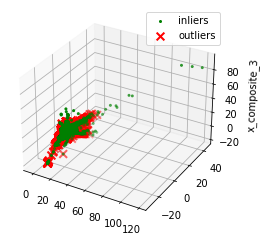

In [28]:


##Plot##################

from sklearn.decomposition import PCA
outlier_index=list(filtered.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(dfIQR)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

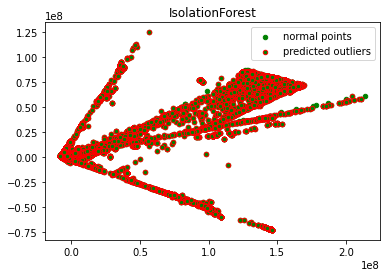

In [29]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(dfIQR)
res=pd.DataFrame(pca.transform(dfIQR))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [30]:
# initial plot
df1 = df.copy()
dfInit=df1.shape[0]
print(df1.shape[0])

# Function to identify and remove outliers
def outliers(df, level):

    # 1. temporary dataframe
    dft = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = dft[(np.abs(stats.zscore(dft)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

# remove outliers
level = 5
print("level = " + str(level))
df_clean = outliers(df = df1, level = level)
noutliers=df1.shape[0]-df_clean.shape[0]
# final plot
print("Removed " + str(noutliers) +" Outliers")

336090
level = 5
Removed 43132 Outliers
